In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

In [3]:
root_directory = ".."
directory = "User-Revenue-Analytics/files/"  

Loading CSV files

In [5]:
file_name = "installs.csv"
file_path = os.path.join(root_directory, directory, file_name)
df_installs = pd.read_csv(file_path)


file_name = "iap.csv"
file_path = os.path.join(root_directory, directory, file_name)
df_iap = pd.read_csv(file_path)

file_name = "rv.csv"
file_path = os.path.join(root_directory, directory, file_name)
df_rv = pd.read_csv(file_path)


combined three DataFrames: df_installs with df_rv, df_installs with df_iap, and merged both results into df_merge.

In [6]:
df_inst_rv_merge = df_installs.merge(df_rv, how='left',on='user_id')
df_inst_iap_merge = df_installs.merge(df_iap, how='left',on='user_id')
df_merge = df_inst_rv_merge.merge(df_inst_iap_merge,how='outer',indicator=True)


function calculating the time difference in hours between two datetime objects

In [6]:
df_merge['install_time'] = pd.to_datetime(df_merge['install_time'])
df_merge['date'] = pd.to_datetime(df_merge['date'])

def passed_hours(install_time, revenue_time):
    time_difference = pd.Timestamp(revenue_time) - pd.Timestamp(install_time)
    return (time_difference.total_seconds() / 3600)




Added two new columns for revenues generated at the end of the day and within 24 hours after downloading the game

In [7]:
df_merge.insert(2,column = "first_24hours_revenue", value =0) 
df_merge.insert(3,column = "end_of_day_revenue", value =0)

identifying revenues generated at the end of the day and within 24 hours after downloading, then adding them to the dataset

In [ ]:
# this part may take 10-12 minutes
for index, row in tqdm(df_merge.iterrows(), total=len(df_merge)):
    install_time = row['install_time']
    date = row['date']
    time = row['time']
    purchase_value = row['purchase_value']
    ad_revenue = row['ad_revenue']
    
    if not pd.isna(time):
        if passed_hours(install_time, time) <= 24:
            df_merge.at[index, 'first_24hours_revenue'] = purchase_value
        if install_time.date() == pd.to_datetime(time).date():
            df_merge.at[index, 'end_of_day_revenue'] = purchase_value
            
    if not pd.isna(date):
        if install_time.date() == date.date():
            df_merge.at[index, 'end_of_day_revenue'] = ad_revenue
            df_merge.at[index, 'first_24hours_revenue'] = ad_revenue

In this section, I calculate various ARPU metrics based on the data:

In [9]:
total_purchase = df_merge['purchase_value'].sum()
unique_users = df_installs['user_id'].nunique()
total_ad_revenue = df_rv['ad_revenue'].sum()
total_1day_revenue = df_merge['first_24hours_revenue'].sum()
total_end_of_1day_revenue = df_merge['end_of_day_revenue'].sum()

In [10]:

iap_arpu = total_purchase / unique_users
rv_arpu = total_ad_revenue / unique_users
overall_arpu = iap_arpu + rv_arpu
end_of_1day_arpu = total_end_of_1day_revenue / unique_users
day1_ARPU = total_1day_revenue / unique_users



In [11]:

print('iap_arpu :', iap_arpu)
print('rv_arpu :', rv_arpu)
print('overall_arpu :', overall_arpu )
print('first_24hours_revenue_ARPU :', day1_ARPU)
print('end_of_1day_arpu :', end_of_1day_arpu)

iap_arpu : 0.7937312154068215
rv_arpu : 0.45701563835608755
overall_arpu : 1.250746853762909
first_24hours_revenue_ARPU : 0.3430026700855399
end_of_1day_arpu : 0.2765293628219536


extracting the years from the 'install_time' column in df_installs, then creating a dictionary dates_dict to count the occurrences of each unique year

In [12]:
years = [dt.split()[0].split('-')[0] for dt in (df_installs['install_time'])]
dates_dict = {}

unique_dates= pd.Series(years).unique().tolist()
for i in unique_dates:
    dates_dict[i] = years.count(i)


sorting and extracting the first 13 items from the dates_dict dictionary, calculating the total count of installs for these years, and howing the install count per year

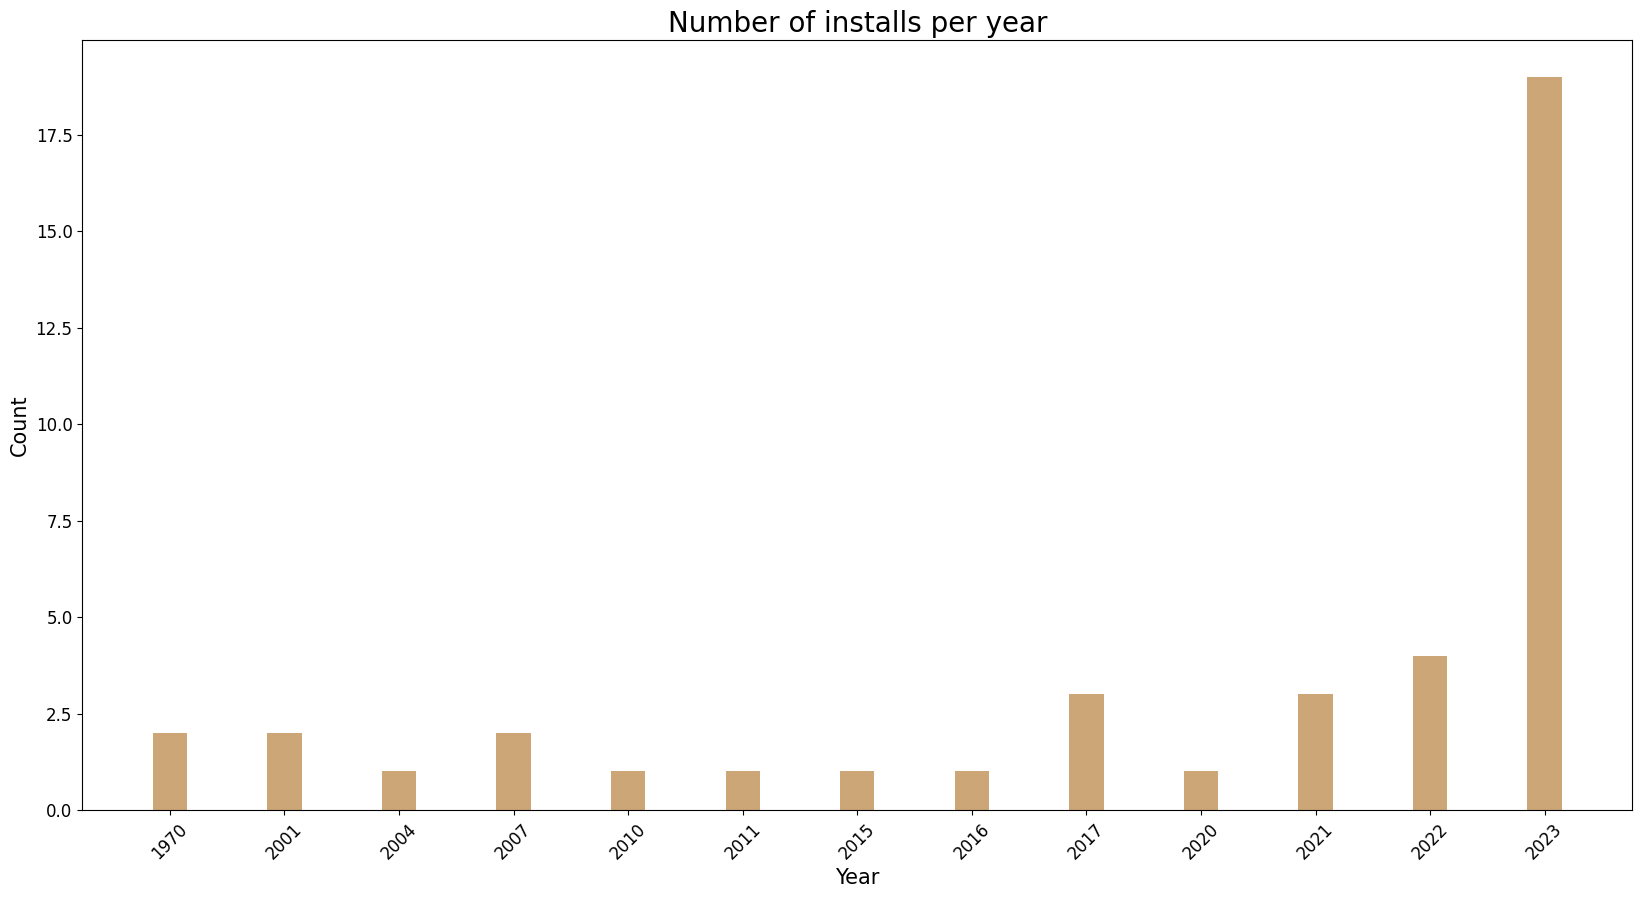

In [18]:


sorted_data = sorted(dates_dict.items())
sum_count = 0
x = [item[0] for item in sorted_data[:13]]
y = [item[1] for item in sorted_data[:13]]
for item in sorted_data[:13]:
    sum_count += item[1]

plt.figure(figsize=(20, 10))
plt.bar(x, y, color='#cca677ff', width=0.3)

plt.title('Number of installs per year', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Count', fontsize=15)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.show()



Finding annormal data in IAP and RV: count of users that generated revenue but are not included in installed data.

In [8]:
unique_rv_id = df_rv['user_id'].unique()
unique_iap_id = df_iap['user_id'].unique()

set_rv = set(unique_rv_id)
set_installs =set(df_installs['user_id'])
set_iap = set(unique_iap_id)

result_rv= np.array(list(set_rv - set_installs))
result_iap =  np.array(list(set_iap - set_installs))

print("Count of Anomalies in rv.csv data:", len(result_rv))
print("Count of Anomalies in iap.csv data:", len(result_iap))


Count of Anomalies in rv.csv data: 2709
Count of Anomalies in iap.csv data: 37


In [25]:

result_user_rv = np.array(list( set_installs-set_rv))
result_user_iap = np.array(list( set_installs-set_iap))
count_installs = len(set_installs)
count_rv =  count_installs - len(result_user_rv)
count_iap = count_installs  - len(result_user_iap)
print(f"Number of users who have generated ad revenue at least once : {count_rv} -> {round(count_rv * 100 / count_installs,2)}%")
print(f"Number of users who have generated monetary value from purchases at least once {count_iap} -> {round(count_iap * 100 / count_installs,2)}%")
print(f"Number of installs  {count_installs}")

Number of users who have generated ad revenue at least once : 941485 -> 65.77%
Number of users who have generated monetary value from purchases at least once 34888 -> 2.44%
Number of installs  1431512
